In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from functools import reduce

In [3]:
# Setup

import pandas as pd
import os
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

dbuname = 'postgres'
dbpassword = 'postgres'
dbhost = 'ais-hack.cirquhp75zcc.us-east-2.rds.amazonaws.com'
dbport = '5432'
dbname = 'aishackathon'

import sqlalchemy
import psycopg2


In [4]:
connection_str = 'postgresql+psycopg2://'+dbuname+':'+dbpassword+'@'+dbhost+':'+dbport+'/'+dbname

In [5]:
try:
    engine = sqlalchemy.create_engine(connection_str)
    conn = engine.connect()
except:
    print('Database connection error - check creds')

In [17]:
#checks 


#count 
pd.read_sql("select count(*) from public.country_metrics",con=engine)

,count
0,3153


### countries distribution 

In [31]:
#count per country
pd.read_sql("select country, count(*) from public.country_metrics group by country",con=engine)

,country,count
0,sb,438
1,ws,90
2,wsm,160
3,kir,264
4,fj,1059
5,vn,348
6,ck,677
7,PW,117


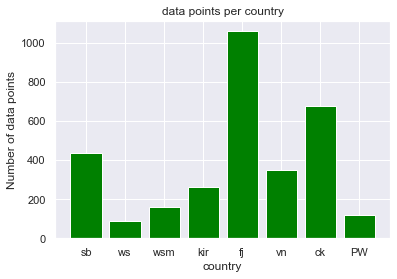

In [35]:
plt.bar(count['country'], count['count'], color='green')

plt.xlabel("country")
plt.ylabel("Number of data points")
plt.title("data points per country")

plt.show()

In [38]:
#category per country 

count_category = pd.read_sql("select country, category, count(*) from public.country_metrics group by country, category",con=engine)

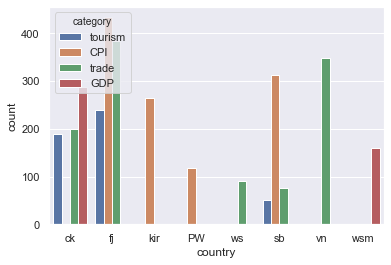

In [48]:
sns.barplot(x="country", hue="category", y="count", data=count_category)
plt.show()

In [ ]:
#alex comments 

#looking at countries more dependent on trade (imports and exports)
#looking at countries from different regions 

#PNG and SB, Fiji (micronesie - more exports)
#Tuvalu and Kiribati (highly dependent on trade)
#Marshall Islands and Palau/Naru (100% GDP is trade)

In [ ]:
#focus on CK, FJ, SB

In [156]:
pd.read_sql("select country, category, frequency, count(*) from public.country_metrics  group by country, category, frequency",con=engine)


,country,category,frequency,count
0,wsm,GDP,quartely,160
1,fj,CPI,monthly,434
2,ws,trade,monthly,90
3,fj,tourism,monthly,240
4,ck,trade,monthly,200
5,sb,tourism,quarterly,51
6,PW,CPI,quartely,117
7,kir,CPI,monthly,264
8,ck,GDP,quartely,288
9,vn,trade,monthly,288


In [49]:
# correlation between trade data and economic indicator 

correlation_trade_eco = pd.read_sql("select * from public.country_metrics where country = 'ck' or country = 'fj' or country = 'sb'",con=engine)


In [52]:
pd.read_sql("select country, category, frequency, count(*) from public.country_metrics where country = 'ck' or country = 'fj' or country = 'sb' group by country, category, frequency",con=engine)


,country,category,frequency,count
0,fj,CPI,monthly,434
1,fj,tourism,monthly,240
2,ck,trade,monthly,200
3,sb,tourism,quarterly,51
4,ck,GDP,quartely,288
5,fj,trade,monthly,385
6,ck,tourism,monthly,189
7,sb,CPI,monthly,312
8,sb,trade,monthly,75


In [143]:
trade_fiji['name'].unique()

array(['exports-fob-domestic', 'exports-fob-reexport',
       'exports-fob-total', 'imports-cif', 'trade-balance'], dtype=object)

In [179]:
# Fiji correlation IMPORT 

#correlation_trade_eco_fiji = pd.read_sql("select * from public.country_metrics where country = 'fj'",con=engine)
trade_fiji_import = pd.read_sql("select * from public.country_metrics where country = 'fj' and category = 'trade' and name = 'imports-cif'",con=engine) 
cpi_fiji = pd.read_sql("select * from public.country_metrics where country = 'fj' and category = 'CPI'",con=engine)
tourism_fiji = pd.read_sql("select * from public.country_metrics where country = 'fj' and category = 'tourism'",con=engine)

In [180]:
#convert to datetime 
trade_fiji_import['date_cleaned'] = pd.to_datetime(trade_fiji_import['date'])
cpi_fiji['date_cleaned'] = pd.to_datetime(cpi_fiji['date'])

In [181]:
#filter total CPI 
cpi_fiji_total = cpi_fiji[cpi_fiji['name'] == 'CPI_2014_Total']
#merge 
import_CPI_fiji = trade_fiji_import.merge(cpi_fiji_total, on='date_cleaned')
#set index
import_CPI_fiji = import_CPI_fiji.set_index('date_x')
#correlation
import_CPI_fiji['value_x'].astype(float).corr(import_CPI_fiji['value_y'].astype(float))

0.010195816224365826

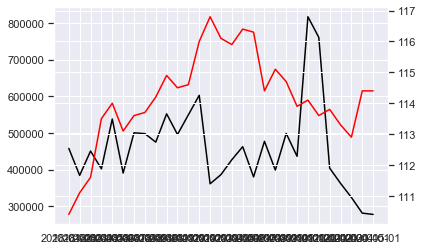

In [182]:
#visualisation 
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(import_CPI_fiji['value_x'].astype(float), color='black')
ax_right.plot(import_CPI_fiji['value_y'].astype(float), color='red')

In [184]:
#filter other CPIs - Goods 
cpi_fiji_goods = cpi_fiji[cpi_fiji['name'] == 'CPI_2014_Food and Non-alcoholic Beverage']
#merge 
import_CPI_fiji = trade_fiji_import.merge(cpi_fiji_goods, on='date_cleaned')
#set index
import_CPI_fiji = import_CPI_fiji.set_index('date_x')
#correlation
import_CPI_fiji['value_x'].astype(float).corr(import_CPI_fiji['value_y'].astype(float))

-0.24507950826642502

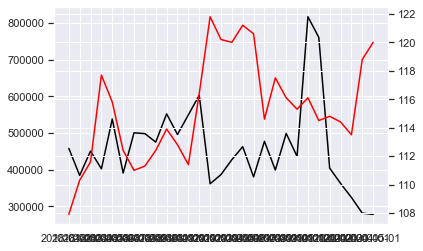

In [185]:
#visualisation 
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(import_CPI_fiji['value_x'].astype(float), color='black')
ax_right.plot(import_CPI_fiji['value_y'].astype(float), color='red')

In [186]:
# Fiji correlation TRADE BALANCE  


trade_fiji = pd.read_sql("select * from public.country_metrics where country = 'fj' and category = 'trade' and name = 'trade-balance'",con=engine) 
cpi_fiji = pd.read_sql("select * from public.country_metrics where country = 'fj' and category = 'CPI'",con=engine)
tourism_fiji = pd.read_sql("select * from public.country_metrics where country = 'fj' and category = 'tourism'",con=engine)

In [187]:
#convert to datetime 
trade_fiji['date_cleaned'] = pd.to_datetime(trade_fiji['date'])
cpi_fiji['date_cleaned'] = pd.to_datetime(cpi_fiji['date'])

In [188]:
#filter total CPI 
cpi_fiji_total = cpi_fiji[cpi_fiji['name'] == 'CPI_2014_Total']
#merge 
trade_CPI_fiji = trade_fiji.merge(cpi_fiji_total, on='date_cleaned')
#set index
trade_CPI_fiji = trade_CPI_fiji.set_index('date_x')
#correlation
trade_CPI_fiji['value_x'].astype(float).corr(trade_CPI_fiji['value_y'].astype(float))

0.05905150736623132

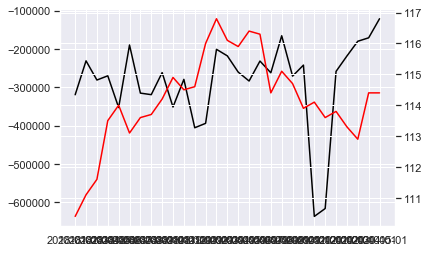

In [189]:
#visualisation 
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(trade_CPI_fiji['value_x'].astype(float), color='black')
ax_right.plot(trade_CPI_fiji['value_y'].astype(float), color='red')

In [190]:
#filter other CPIs - Goods 
cpi_fiji_goods = cpi_fiji[cpi_fiji['name'] == 'CPI_2014_Food and Non-alcoholic Beverage']
trade_CPI_fiji = trade_fiji.merge(cpi_fiji_goods, on='date_cleaned')
trade_CPI_fiji = trade_CPI_fiji.set_index('date_x')
trade_CPI_fiji['value_x'].astype(float).corr(trade_CPI_fiji['value_y'].astype(float))

0.2337540800702365

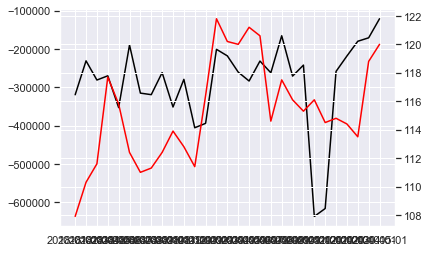

In [191]:
#visualisation 
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(trade_CPI_fiji['value_x'].astype(float), color='black')
ax_right.plot(trade_CPI_fiji['value_y'].astype(float), color='red')

In [192]:
### CPI SOLOMON Islands

In [222]:
cpi_sb['name'].unique()

array(['CPI_2017_Food_non_alcoholic', 'CPI_2017_Alcoholic_tobacco_narco',
       'CPI_2017_Health', 'CPI_2017_Clothing_footwear',
       'CPI_2017_Housing_water_electricity',
       'CPI_2017_Furnishing_equipment', 'CPI_2017_Transport',
       'CPI_2017_Communication', 'CPI_2017_Recreation_Culture',
       'CPI_2017_Education', 'CPI_2017_Restaurants_Hotel',
       'CPI_2017_Miscellaneous', 'CPI_2017_Total'], dtype=object)

In [224]:
#imports - cpi total


trade_sb_import = pd.read_sql("select * from public.country_metrics where country = 'sb' and category = 'trade' and name = 'imports-cif'",con=engine) 
cpi_sb = pd.read_sql("select * from public.country_metrics where country = 'sb' and category = 'CPI'and name = 'CPI_2017_Total'",con=engine)
tourism_sb = pd.read_sql("select * from public.country_metrics where country = 'sb' and category = 'tourism'",con=engine)


In [225]:
#convert to datetime 
trade_sb_import['date_cleaned'] = pd.to_datetime(trade_sb_import['date'])
cpi_sb['date_cleaned'] = pd.to_datetime(cpi_sb['date'])

In [226]:
#merge 
trade_CPI_sb = trade_sb_import.merge(cpi_sb, on='date_cleaned')
#set index
trade_CPI_sb = trade_CPI_sb.set_index('date_x')
#correlation
trade_CPI_sb['value_x'].astype(float).corr(trade_CPI_sb['value_y'].astype(float))

-0.031580325943434545

In [227]:
#trade balance  

trade_sb_balance = pd.read_sql("select * from public.country_metrics where country = 'sb' and category = 'trade' and name = 'trade-balance'",con=engine) 


In [228]:
#convert to datetime 
trade_sb_balance['date_cleaned'] = pd.to_datetime(trade_sb_balance['date'])

In [230]:
#merge 
trade_CPI_sb = trade_sb_balance.merge(cpi_sb, on='date_cleaned')
#set index
trade_CPI_sb = trade_CPI_sb.set_index('date_x')
#correlation
trade_CPI_sb['value_x'].astype(float).corr(trade_CPI_sb['value_y'].astype(float))

0.07914368983352302

In [233]:
#### CPI - Goods 


#imports 


trade_sb_import = pd.read_sql("select * from public.country_metrics where country = 'sb' and category = 'trade' and name = 'imports-cif'",con=engine) 
cpi_sb = pd.read_sql("select * from public.country_metrics where country = 'sb' and category = 'CPI'and name = 'CPI_2017_Food_non_alcoholic'",con=engine)


In [234]:
#convert to datetime 
trade_sb_import['date_cleaned'] = pd.to_datetime(trade_sb_import['date'])
cpi_sb['date_cleaned'] = pd.to_datetime(cpi_sb['date'])

#merge 
trade_CPI_sb = trade_sb_import.merge(cpi_sb, on='date_cleaned')
#set index
trade_CPI_sb = trade_CPI_sb.set_index('date_x')
#correlation
trade_CPI_sb['value_x'].astype(float).corr(trade_CPI_sb['value_y'].astype(float))


-0.18766440505372362

In [235]:
# trade balance - cpi goods 

#merge 
trade_CPI_sb = trade_sb_balance.merge(cpi_sb, on='date_cleaned')
#set index
trade_CPI_sb = trade_CPI_sb.set_index('date_x')
#correlation
trade_CPI_sb['value_x'].astype(float).corr(trade_CPI_sb['value_y'].astype(float))

0.011169514991383066

In [236]:
cpi_sb = pd.read_sql("select * from public.country_metrics where country = 'sb' and category = 'CPI'and name = 'CPI_2017_Alcoholic_tobacco_narco'",con=engine)

cpi_sb['date_cleaned'] = pd.to_datetime(cpi_sb['date'])

#merge 
trade_CPI_sb = trade_sb_import.merge(cpi_sb, on='date_cleaned')
#set index
trade_CPI_sb = trade_CPI_sb.set_index('date_x')
#correlation
trade_CPI_sb['value_x'].astype(float).corr(trade_CPI_sb['value_y'].astype(float))


-0.03521490436594545

In [237]:
#merge 
trade_CPI_sb = trade_sb_balance.merge(cpi_sb, on='date_cleaned')
#set index
trade_CPI_sb = trade_CPI_sb.set_index('date_x')
#correlation
trade_CPI_sb['value_x'].astype(float).corr(trade_CPI_sb['value_y'].astype(float))

0.14305064283148533

In [244]:
#CK GDP 


trade_ck_import = pd.read_sql("select * from public.country_metrics where country = 'ck' and category = 'trade' and name = 'imports-cif'",con=engine) 
gdp_ck = pd.read_sql("select * from public.country_metrics where country = 'ck' and category = 'GDP' and name ='GDP_Goods-producing industries'",con=engine)


In [248]:
gdp_ck['date'].head()

0    Jun-17
1    Sep-17
2    Dec-17
3    Mar-18
4    Jun-18
Name: date, dtype: object

In [252]:
gdp_ck['date'] = pd.to_datetime(gdp_ck['date'], format='%b-%y')

In [253]:
#convert  datetime 
trade_ck_import['date_cleaned'] = pd.to_datetime(trade_ck_import['date'])
gdp_ck['date_cleaned'] = pd.to_datetime(gdp_ck['date'])

#merge 
trade_GDP_ck = trade_ck_import.merge(gdp_ck, on='date_cleaned')
#set index
trade_GDP_ck = trade_GDP_ck.set_index('date_x')
#correlation
trade_GDP_ck['value_x'].astype(float).corr(trade_GDP_ck['value_y'].astype(float))


0.45455469250300695

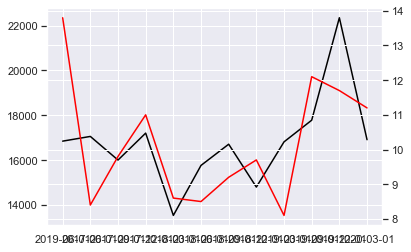

In [254]:
#visualisation 
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(trade_GDP_ck['value_x'].astype(float), color='black')
ax_right.plot(trade_GDP_ck['value_y'].astype(float), color='red')

In [259]:
#export 


trade_ck_export = pd.read_sql("select * from public.country_metrics where country = 'ck' and category = 'trade' and name = 'exports-fob-total'",con=engine) 

In [260]:
#convert  datetime 
trade_ck_export['date_cleaned'] = pd.to_datetime(trade_ck_export['date'])
gdp_ck['date_cleaned'] = pd.to_datetime(gdp_ck['date'])

#merge 
trade_GDP_ck = trade_ck_export.merge(gdp_ck, on='date_cleaned')
#set index
trade_GDP_ck = trade_GDP_ck.set_index('date_x')
#correlation
trade_GDP_ck['value_x'].astype(float).corr(trade_GDP_ck['value_y'].astype(float))


0.037669593008298